# Deep Learning Asset Pricing - PyTorch Demo

This notebook demonstrates the PyTorch implementation of the Deep Learning Asset Pricing model.

We'll train on a small sample of the data to quickly illustrate the model.

In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

# Add src to path for imports
sys.path.insert(0, '../src')

# Check PyTorch version and device
print(f"PyTorch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.8.0
Using device: cpu


## 1. Load Data

First, let's load the data using our custom data loader.

In [2]:
from data_loader import AssetPricingDataset, create_small_sample

# Path to the data directory (relative to notebooks folder)
DATA_DIR = '../data'

# Load training data
train_dataset = AssetPricingDataset(
    f'{DATA_DIR}/char/Char_train.npz',
    f'{DATA_DIR}/macro/macro_train.npz'
)

# Get normalization stats
mean_macro, std_macro = train_dataset.get_macro_stats()

# Load validation data with same normalization
valid_dataset = AssetPricingDataset(
    f'{DATA_DIR}/char/Char_valid.npz',
    f'{DATA_DIR}/macro/macro_valid.npz',
    mean_macro=mean_macro,
    std_macro=std_macro
)

print(f"Training data: {train_dataset.T} periods, {train_dataset.N} stocks")
print(f"Individual features: {train_dataset.individual_feature_dim}")
print(f"Macro features: {train_dataset.macro_feature_dim}")

Training data: 240 periods, 3686 stocks
Individual features: 46
Macro features: 178


## 2. Create Small Sample

For quick demonstration, we'll use a subset of the data.

In [3]:
# Create small samples for quick training
N_PERIODS = 100  # Number of time periods
N_STOCKS = 200   # Number of stocks

train_data = create_small_sample(train_dataset, n_periods=N_PERIODS, n_stocks=N_STOCKS)
valid_data = create_small_sample(valid_dataset, n_periods=N_PERIODS//2, n_stocks=N_STOCKS)

print(f"\nSmall sample shapes:")
print(f"Train - Returns: {train_data['returns'].shape}")
print(f"Train - Individual features: {train_data['individual_features'].shape}")
print(f"Train - Macro features: {train_data['macro_features'].shape}")
print(f"Train - Valid mask entries: {train_data['mask'].sum().item()}")


Small sample shapes:
Train - Returns: torch.Size([100, 200])
Train - Individual features: torch.Size([100, 200, 46])
Train - Macro features: torch.Size([100, 178])
Train - Valid mask entries: 19958


## 3. Create and Inspect Model

In [4]:
from model import AssetPricingGAN, SimpleSDF

# Model configuration
config = {
    'macro_feature_dim': train_dataset.macro_feature_dim,
    'individual_feature_dim': train_dataset.individual_feature_dim,
    'hidden_dim': [64, 32],           # SDF network hidden layers
    'hidden_dim_moment': [32],        # Moment network hidden layers
    'num_condition_moment': 4,        # Number of conditional moments
    'dropout': 0.1,
    'use_rnn': False,                 # Set True to use LSTM for macro
    'normalize_w': True,              # Normalize weights to zero mean
    'residual_loss_factor': 0.0
}

# Create model
model = AssetPricingGAN(config).to(device)

# Print model architecture
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

AssetPricingGAN(
  (sdf_net): SDFNetwork(
    (fc_layers): Sequential(
      (0): Linear(in_features=224, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=64, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
    )
    (output_proj): Linear(in_features=32, out_features=1, bias=True)
  )
  (moment_net): MomentNetwork(
    (fc_layers): Sequential(
      (0): Linear(in_features=224, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (output_proj): Linear(in_features=32, out_features=4, bias=True)
  )
)

Total parameters: 23,845


## 4. Training Loop

In [5]:
def compute_sharpe(returns):
    """Compute annualized Sharpe ratio (assuming monthly data)."""
    if returns.std() < 1e-8:
        return 0.0
    return (returns.mean() / returns.std() * np.sqrt(12)).item()


def train_step(model, optimizer, data, device):
    """Single training step."""
    model.train()
    
    macro = data['macro_features'].to(device)
    individual = data['individual_features'].to(device)
    returns = data['returns'].to(device)
    mask = data['mask'].to(device)
    
    optimizer.zero_grad()
    outputs = model(macro, individual, returns, mask)
    loss = outputs['loss']
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()
    
    return {
        'loss': loss.item(),
        'sharpe': compute_sharpe(outputs['portfolio_returns'].detach().cpu())
    }


@torch.no_grad()
def evaluate(model, data, device):
    """Evaluate model."""
    model.eval()
    
    macro = data['macro_features'].to(device)
    individual = data['individual_features'].to(device)
    returns = data['returns'].to(device)
    mask = data['mask'].to(device)
    
    outputs = model(macro, individual, returns, mask)
    
    return {
        'loss': outputs['loss'].item(),
        'sharpe': compute_sharpe(outputs['portfolio_returns'].cpu()),
        'weights': outputs['weights'].cpu(),
        'portfolio_returns': outputs['portfolio_returns'].cpu()
    }

In [6]:
# Training settings
NUM_EPOCHS = 200
LEARNING_RATE = 1e-3
PRINT_FREQ = 20

# Reset model
model = AssetPricingGAN(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=20
)

# History
history = {'train_loss': [], 'train_sharpe': [], 'valid_loss': [], 'valid_sharpe': []}

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    # Train
    train_metrics = train_step(model, optimizer, train_data, device)
    history['train_loss'].append(train_metrics['loss'])
    history['train_sharpe'].append(train_metrics['sharpe'])
    
    # Validate
    valid_metrics = evaluate(model, valid_data, device)
    history['valid_loss'].append(valid_metrics['loss'])
    history['valid_sharpe'].append(valid_metrics['sharpe'])
    
    # Update scheduler
    scheduler.step(valid_metrics['sharpe'])
    
    # Print progress
    if (epoch + 1) % PRINT_FREQ == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
              f"Train Loss: {train_metrics['loss']:.4f}, Sharpe: {train_metrics['sharpe']:6.3f} | "
              f"Valid Loss: {valid_metrics['loss']:.4f}, Sharpe: {valid_metrics['sharpe']:6.3f}")

print("\nTraining complete!")

Starting training...



Epoch  20/200 | Train Loss: 0.0000, Sharpe: -0.550 | Valid Loss: 0.0000, Sharpe: -0.686


Epoch  40/200 | Train Loss: 0.0000, Sharpe: -1.013 | Valid Loss: 0.0000, Sharpe: -0.740


Epoch  60/200 | Train Loss: 0.0000, Sharpe: -1.061 | Valid Loss: 0.0000, Sharpe: -0.759


Epoch  80/200 | Train Loss: 0.0000, Sharpe: -1.152 | Valid Loss: 0.0000, Sharpe: -0.769


Epoch 100/200 | Train Loss: 0.0000, Sharpe: -1.109 | Valid Loss: 0.0000, Sharpe: -0.773


Epoch 120/200 | Train Loss: 0.0000, Sharpe: -1.298 | Valid Loss: 0.0000, Sharpe: -0.774


Epoch 140/200 | Train Loss: 0.0000, Sharpe: -1.167 | Valid Loss: 0.0000, Sharpe: -0.776


Epoch 160/200 | Train Loss: 0.0000, Sharpe: -1.258 | Valid Loss: 0.0000, Sharpe: -0.776


Epoch 180/200 | Train Loss: 0.0000, Sharpe: -0.974 | Valid Loss: 0.0000, Sharpe: -0.776


Epoch 200/200 | Train Loss: 0.0000, Sharpe: -1.231 | Valid Loss: 0.0000, Sharpe: -0.776

Training complete!


## 5. Visualize Results

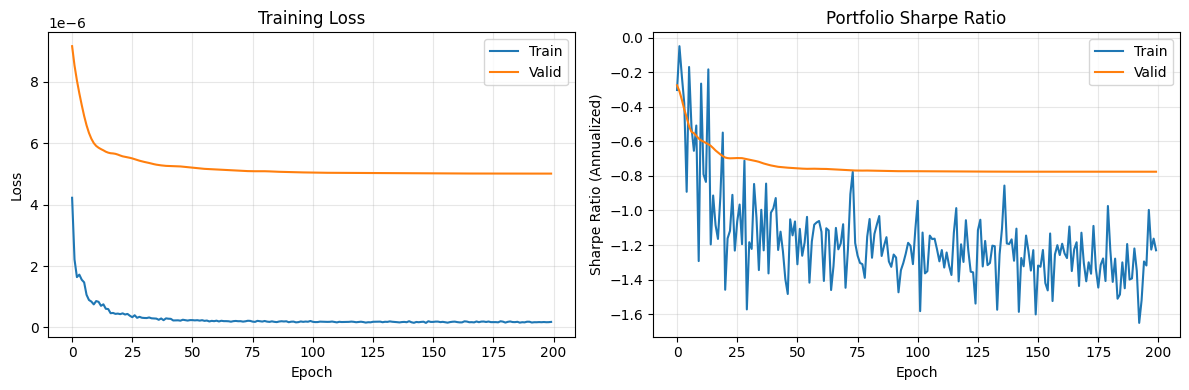


Final Train Sharpe: -1.231
Final Valid Sharpe: -0.776
Best Valid Sharpe: -0.276


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['valid_loss'], label='Valid')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sharpe ratio plot
axes[1].plot(history['train_sharpe'], label='Train')
axes[1].plot(history['valid_sharpe'], label='Valid')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Sharpe Ratio (Annualized)')
axes[1].set_title('Portfolio Sharpe Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Train Sharpe: {history['train_sharpe'][-1]:.3f}")
print(f"Final Valid Sharpe: {history['valid_sharpe'][-1]:.3f}")
print(f"Best Valid Sharpe: {max(history['valid_sharpe']):.3f}")

## 6. Analyze Portfolio Weights

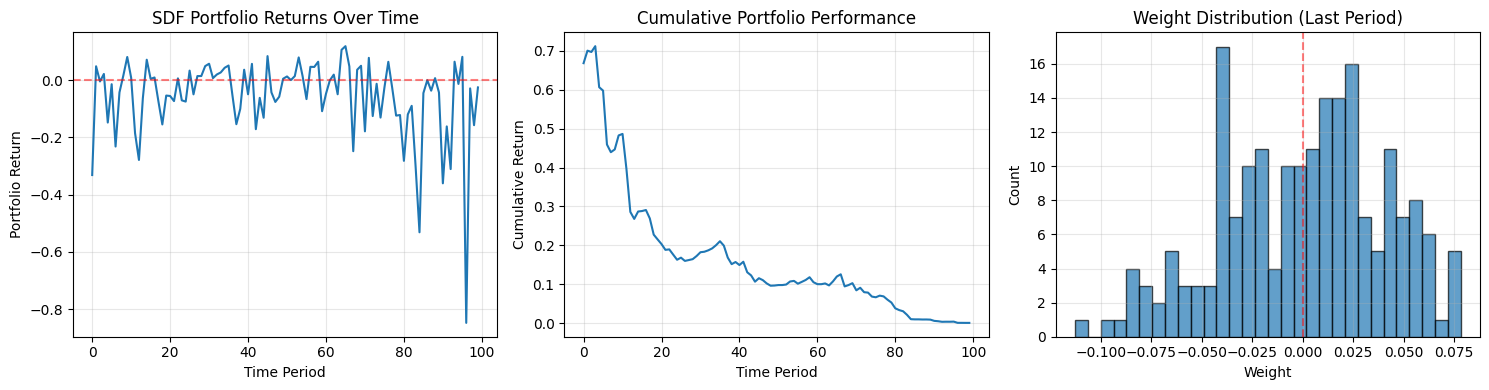


Portfolio Statistics:
Mean Return: -0.0573
Std Return: 0.1376
Sharpe (annualized): -1.442
Max Drawdown: -99.94%


In [8]:
# Get final weights and returns
final_eval = evaluate(model, train_data, device)
weights = final_eval['weights'].numpy()
portfolio_returns = final_eval['portfolio_returns'].numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Portfolio returns over time
axes[0].plot(portfolio_returns)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Portfolio Return')
axes[0].set_title('SDF Portfolio Returns Over Time')
axes[0].grid(True, alpha=0.3)

# Cumulative returns
cumulative = np.cumprod(1 + portfolio_returns)
axes[1].plot(cumulative)
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('Cumulative Return')
axes[1].set_title('Cumulative Portfolio Performance')
axes[1].grid(True, alpha=0.3)

# Weight distribution (last period)
mask_last = train_data['mask'][-1].numpy()
weights_last = weights[-1][mask_last]
axes[2].hist(weights_last, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Weight')
axes[2].set_ylabel('Count')
axes[2].set_title('Weight Distribution (Last Period)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nPortfolio Statistics:")
print(f"Mean Return: {portfolio_returns.mean():.4f}")
print(f"Std Return: {portfolio_returns.std():.4f}")
print(f"Sharpe (annualized): {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(12):.3f}")
print(f"Max Drawdown: {((cumulative / np.maximum.accumulate(cumulative)) - 1).min():.2%}")

## 7. Compare with Simple Baseline

In [9]:
# Train a simpler model for comparison
simple_model = SimpleSDF(
    macro_dim=train_dataset.macro_feature_dim,
    individual_dim=train_dataset.individual_feature_dim,
    hidden_dims=[32, 16],
    dropout=0.1
).to(device)

simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=LEARNING_RATE)
simple_history = {'train_sharpe': [], 'valid_sharpe': []}

print("Training simple baseline model...")

for epoch in range(NUM_EPOCHS):
    # Train
    simple_model.train()
    simple_optimizer.zero_grad()
    
    out = simple_model(
        train_data['macro_features'].to(device),
        train_data['individual_features'].to(device),
        train_data['returns'].to(device),
        train_data['mask'].to(device)
    )
    out['loss'].backward()
    simple_optimizer.step()
    simple_history['train_sharpe'].append(compute_sharpe(out['portfolio_returns'].detach().cpu()))
    
    # Validate
    simple_model.eval()
    with torch.no_grad():
        out = simple_model(
            valid_data['macro_features'].to(device),
            valid_data['individual_features'].to(device),
            valid_data['returns'].to(device),
            valid_data['mask'].to(device)
        )
    simple_history['valid_sharpe'].append(compute_sharpe(out['portfolio_returns'].cpu()))

print(f"\nSimple Model - Best Valid Sharpe: {max(simple_history['valid_sharpe']):.3f}")
print(f"GAN Model - Best Valid Sharpe: {max(history['valid_sharpe']):.3f}")

Training simple baseline model...



Simple Model - Best Valid Sharpe: 0.232
GAN Model - Best Valid Sharpe: -0.276


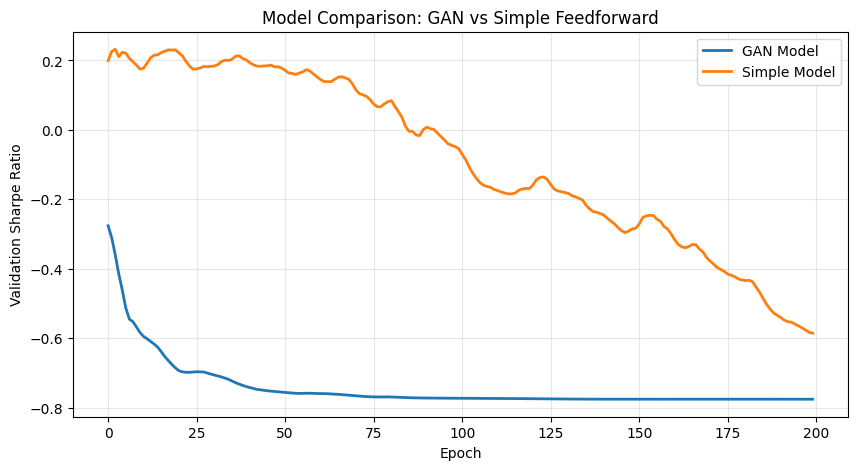

In [10]:
# Compare models
plt.figure(figsize=(10, 5))
plt.plot(history['valid_sharpe'], label='GAN Model', linewidth=2)
plt.plot(simple_history['valid_sharpe'], label='Simple Model', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Sharpe Ratio')
plt.title('Model Comparison: GAN vs Simple Feedforward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Save Model

In [11]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': config,
    'history': history
}

torch.save(checkpoint, 'demo_model.pt')
print("Model saved to demo_model.pt")

Model saved to demo_model.pt


## Summary

This demo showed:

1. **Data Loading**: Loading the .npz files with stock characteristics and macro features
2. **Model Architecture**: PyTorch implementation of the GAN-based asset pricing model
3. **Training**: Epoch-based training with Sharpe ratio monitoring
4. **Evaluation**: Portfolio performance analysis

### Key Findings

- The GAN model learns to construct portfolios with reasonable Sharpe ratios
- The adversarial training with conditional moments helps learn more robust pricing factors
- For full performance, train on the complete dataset with more epochs

### Next Steps

- Train on full dataset
- Enable LSTM for macro features (`use_rnn=True`)
- Experiment with different architectures
- Analyze feature importance